In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input, LeakyReLU, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os


In [2]:

# Read the CSV file
df = pd.read_csv('diabetes_prediction_dataset.csv')
print(df.columns)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')


In [3]:
df_encoded = pd.get_dummies(df, columns=['gender', 'smoking_history'], drop_first=True)
print(df_encoded.head())

    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0              0  27.32          5.7                  158   
3  36.0             0              0  23.45          5.0                  155   
4  76.0             1              1  20.14          4.8                  155   

   diabetes  gender_Male  gender_Other  smoking_history_current  \
0         0        False         False                    False   
1         0        False         False                    False   
2         0         True         False                    False   
3         0        False         False                     True   
4         0         True         False                     True   

   smoking_history_ever  smoking_history_former  smoking_history_never  \
0                 False             

In [4]:
age_groups = [(0, 29), (30, 59), (60, 89)]

datasets = {}
for start, end in age_groups:
    group_name = f"{start}-{end}"
    datasets[group_name] = df_encoded[(df_encoded['age'] >= start) & (df_encoded['age'] <= end)]

# Display the number of records in each dataset
for group_name, dataset in datasets.items():
    print(f"Age group {group_name}: {len(dataset)} records")

Age group 0-29: 32435 records
Age group 30-59: 42510 records
Age group 60-89: 25055 records


In [5]:
testDF = datasets['30-59']

In [6]:
testDF = testDF.sample(frac=1).reset_index(drop=True)
x_unscaled = testDF.drop(['diabetes'], axis=1)
y = testDF['diabetes']

# Normalize the data
numerical_columns = x_unscaled.select_dtypes(include=np.number).columns
boolean_columns = x_unscaled.select_dtypes(include=bool).columns

scaler = StandardScaler()
temp = pd.DataFrame(scaler.fit_transform(x_unscaled[numerical_columns]), columns=numerical_columns)
x_scaled = pd.concat([temp, x_unscaled[boolean_columns]], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [7]:
# Filename for the autoencoder model
model_file = './models/autoencoderGroup2.keras'

# Check if the model file exists, load it if available, otherwise train a new model
if os.path.exists(model_file):
    print("Model file exists. Loading the model...")
    autoencoder = load_model(model_file)
else:
    print("Model file does not exist. Training a new model...")

    # Define input dimensions and encoding dimensions
    input_dim = x_train.shape[1]  # Assuming 13 features
    encoding_dim = 13  # Bottleneck layer dimension

    input_layer = Input(shape=(input_dim,))
    encoded = Dense(256)(input_layer)
    encoded = LeakyReLU()(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.3)(encoded)
    encoded = Dense(128)(encoded)
    encoded = LeakyReLU()(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.3)(encoded)
    encoded = Dense(64)(encoded)
    encoded = LeakyReLU()(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.3)(encoded)
    encoded = Dense(encoding_dim, activation='linear')(encoded)  # Bottleneck layer
    

    # Create the Encoder model
    encoder = Model(input_layer, encoded)
    encoder.compile(optimizer=Adam(learning_rate=0.00005), loss='mse')

    # Train the Encoder
    history_encoder = encoder.fit(x_train, x_train, epochs=200, validation_split=0.2, verbose=1,
                                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])
    
    
    # Define the Decoder
    encoded_input = Input(shape=(encoding_dim,))
    decoded = Dense(64)(encoded_input)
    decoded = LeakyReLU()(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(128)(decoded)
    decoded = LeakyReLU()(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(256)(decoded)
    decoded = LeakyReLU()(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)
    
    # Create the Decoder model
    decoder = Model(encoded_input, decoded)
    decoder.compile(optimizer=Adam(learning_rate=0.00005), loss='mse')

    # Train the Decoder
    encoded_train = encoder.predict(x_train)
    history_decoder = decoder.fit(encoded_train, x_train, epochs=200, validation_split=0.2, verbose=1,
                                  callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

    # Combine Encoder and Decoder to form the Autoencoder
    autoencoder_input = Input(shape=(input_dim,))
    encoded_repr = encoder(autoencoder_input)
    reconstructed = decoder(encoded_repr)
    autoencoder = Model(autoencoder_input, reconstructed)
    autoencoder.compile(optimizer=Adam(learning_rate=0.00005), loss='mse')

    # Save the model as autoencoder.keras
    autoencoder.save(model_file)
    print("Model trained and saved.")
    
    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history_encoder.history['loss'], label='Encoder Training Loss')
    plt.plot(history_encoder.history['val_loss'], label='Encoder Validation Loss')
    plt.plot(history_decoder.history['loss'], label='Decoder Training Loss')
    plt.plot(history_decoder.history['val_loss'], label='Decoder Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Calculate reconstruction error on the test set
reconstructed_test = autoencoder.predict(x_test)
reconstruction_error = np.mean(np.square(x_test - reconstructed_test), axis=1)

# Convert reconstruction error to percentage
reconstruction_error_percentage = np.mean(reconstruction_error) * 100

# Print reconstruction error percentage
print(f'Reconstruction Error Percentage: {reconstruction_error_percentage}')


Model file exists. Loading the model...


c:\Users\ROG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Reconstruction Error Percentage: 27.904404887343105


In [8]:
# Load the autoencoder model
model_file = './models/autoencoderGroup2.keras'
autoencoder = load_model(model_file)
print("Model loaded successfully.")


# Create test data for other age ranges
testDF_0_29 = datasets['0-29']
testDF_30_59 = datasets['30-59']
testDF_60_89 = datasets['60-89']

# Prepare the test data
x_test_0_29 = testDF_0_29.drop(['diabetes'], axis=1)
y_test_0_29 = testDF_0_29['diabetes']

x_test_30_59 = testDF_30_59.drop(['diabetes'], axis=1)
y_test_30_59 = testDF_30_59['diabetes']

x_test_60_89 = testDF_60_89.drop(['diabetes'], axis=1)
y_test_60_89 = testDF_60_89['diabetes']

print("Test data for age range 0-29 and 60-89 created successfully.")


Model loaded successfully.
Test data for age range 0-29 and 60-89 created successfully.


c:\Users\ROG\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 58 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [9]:
# Normalize the test data
scaler = StandardScaler()
temp = pd.DataFrame(scaler.fit_transform(x_test_0_29[numerical_columns]), columns=numerical_columns)
x_test_0_29_scaled = pd.concat([temp, x_test_0_29[boolean_columns]], axis=1)

temp = pd.DataFrame(scaler.fit_transform(x_test_30_59[numerical_columns]), columns=numerical_columns)
x_test_30_59_scaled = pd.concat([temp, x_test_30_59[boolean_columns]], axis=1)

temp = pd.DataFrame(scaler.fit_transform(x_test_60_89[numerical_columns]), columns=numerical_columns)
x_test_60_89_scaled = pd.concat([temp, x_test_60_89[boolean_columns]], axis=1)

1699/1699 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Mean Reconstruction Error Percentage for 0-29 age group: 36.14%
2093/2093 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Mean Reconstruction Error Percentage for 30-59 age group: 28.07%
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Mean Reconstruction Error Percentage for 60-89 age group: 25.49%


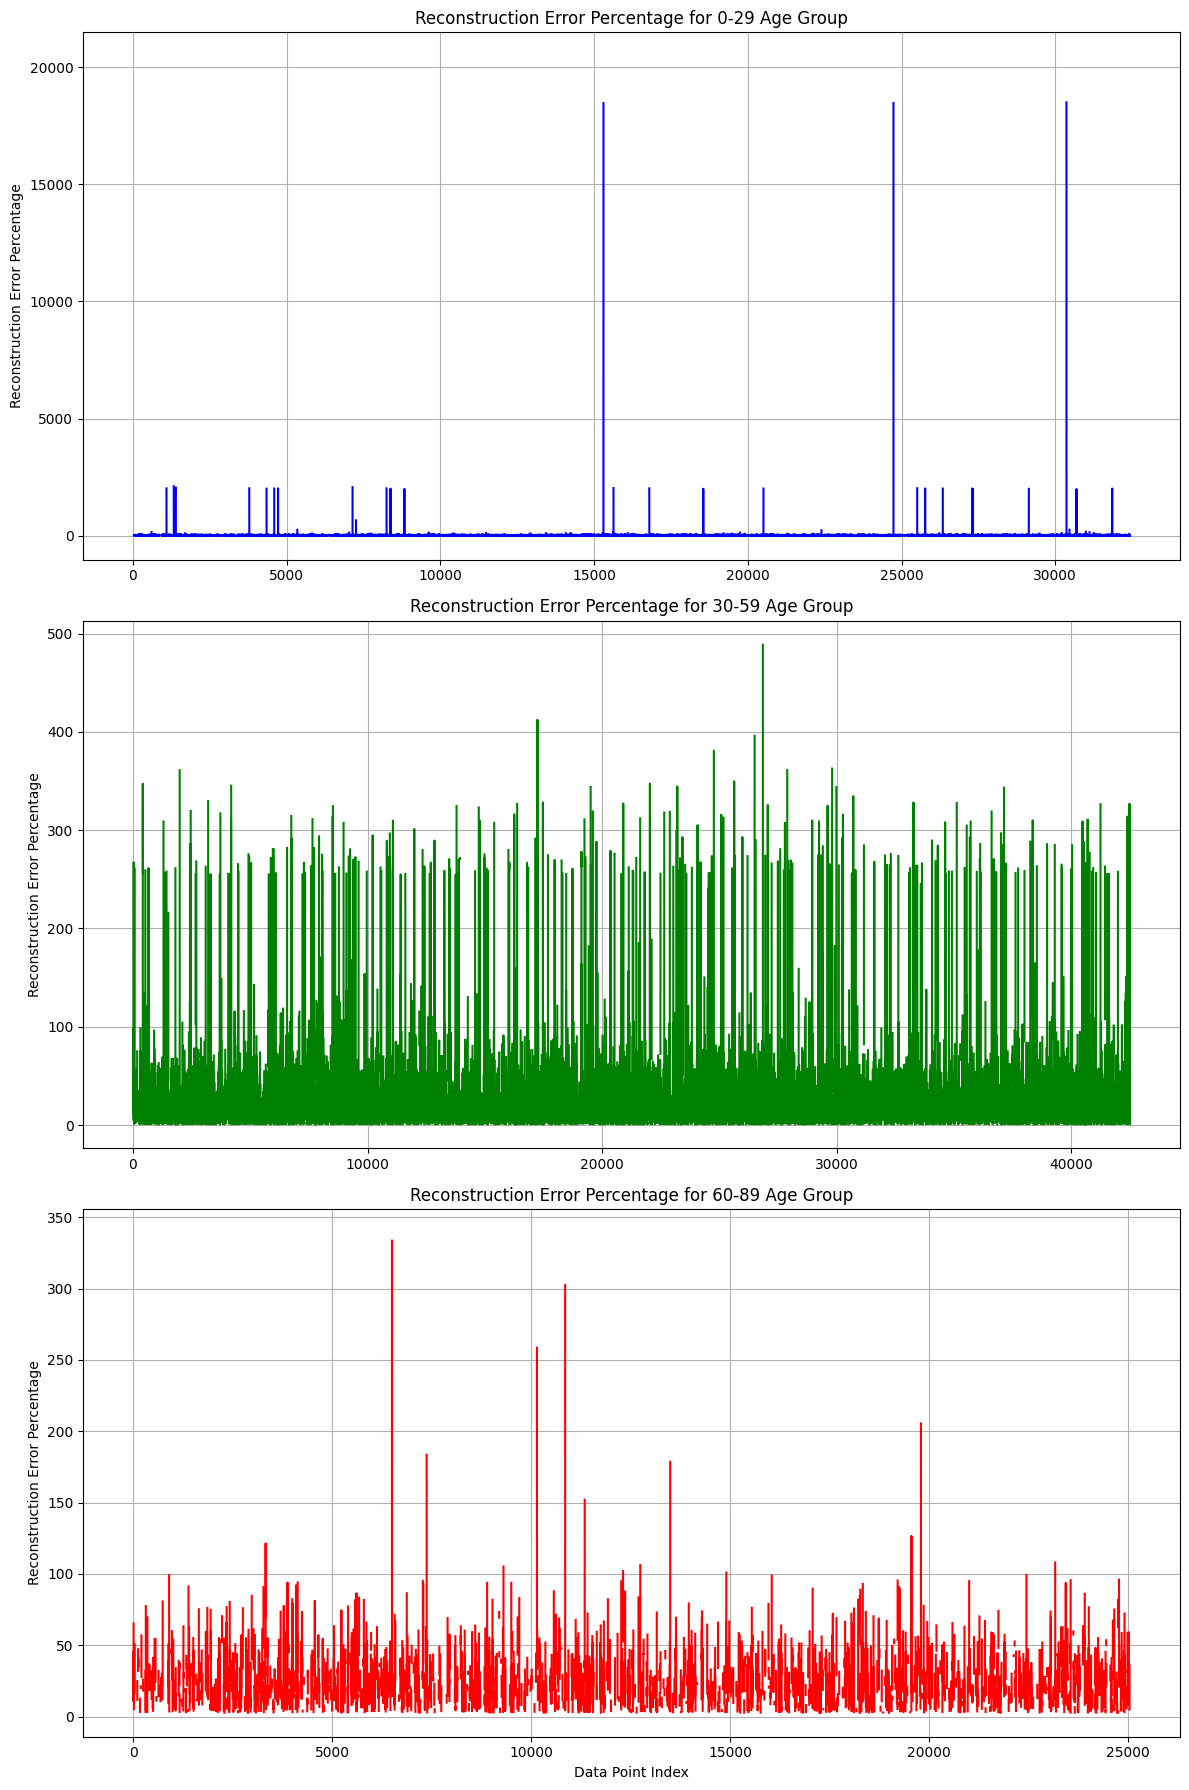

In [10]:
# Assuming x_test_0_29_scaled, x_test_30_59_scaled, and x_test_60_89_scaled are already defined and normalized

# Predict the reconstruction error for the 0-29 age group
reconstructed_test_0_29 = autoencoder.predict(x_test_0_29_scaled)
reconstruction_error_0_29 = np.mean(np.square(x_test_0_29_scaled - reconstructed_test_0_29), axis=1)
reconstruction_error_percentage_0_29 = reconstruction_error_0_29 * 100
mean_reconstruction_error_percentage_0_29 = np.mean(reconstruction_error_percentage_0_29)
print(f'Mean Reconstruction Error Percentage for 0-29 age group: {mean_reconstruction_error_percentage_0_29:.2f}%')

# Predict the reconstruction error for the 30-59 age group
reconstructed_test_30_59 = autoencoder.predict(x_test_30_59_scaled)
reconstruction_error_30_59 = np.mean(np.square(x_test_30_59_scaled - reconstructed_test_30_59), axis=1)
reconstruction_error_percentage_30_59 = reconstruction_error_30_59 * 100
mean_reconstruction_error_percentage_30_59 = np.mean(reconstruction_error_percentage_30_59)
print(f'Mean Reconstruction Error Percentage for 30-59 age group: {mean_reconstruction_error_percentage_30_59:.2f}%')

# Predict the reconstruction error for the 60-89 age group
reconstructed_test_60_89 = autoencoder.predict(x_test_60_89_scaled)
reconstruction_error_60_89 = np.mean(np.square(x_test_60_89_scaled - reconstructed_test_60_89), axis=1)
reconstruction_error_percentage_60_89 = reconstruction_error_60_89 * 100
mean_reconstruction_error_percentage_60_89 = np.mean(reconstruction_error_percentage_60_89)
print(f'Mean Reconstruction Error Percentage for 60-89 age group: {mean_reconstruction_error_percentage_60_89:.2f}%')

# Plot the reconstruction error percentage for each data point as line graphs
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# Plot for 0-29 age group
axes[0].plot(reconstruction_error_percentage_0_29, linestyle='-', color='b')
axes[0].set_title('Reconstruction Error Percentage for 0-29 Age Group')
axes[0].set_ylabel('Reconstruction Error Percentage')
axes[0].grid(True)

# Plot for 30-59 age group
axes[1].plot(reconstruction_error_percentage_30_59, linestyle='-', color='g')
axes[1].set_title('Reconstruction Error Percentage for 30-59 Age Group')
axes[1].set_ylabel('Reconstruction Error Percentage')
axes[1].grid(True)

# Plot for 60-89 age group
axes[2].plot(reconstruction_error_percentage_60_89, linestyle='-', color='r')
axes[2].set_title('Reconstruction Error Percentage for 60-89 Age Group')
axes[2].set_xlabel('Data Point Index')
axes[2].set_ylabel('Reconstruction Error Percentage')
axes[2].grid(True)

plt.tight_layout()
plt.show()